# Requerimiento 4: Clustering Jerárquico de Artículos

## Descripción del Requerimiento

Este notebook implementa **clustering jerárquico aglomerativo** para agrupar artículos científicos según la similitud de sus abstracts.

### Objetivos:
1. **Cargar y procesar** abstracts de artículos desde archivo BibTeX
2. **Limpiar y preprocesar** texto eliminando stopwords y caracteres especiales
3. **Vectorizar** usando TF-IDF para representación numérica
4. **Aplicar clustering jerárquico** con diferentes métodos de enlace
5. **Visualizar** resultados mediante dendrogramas

### Flujo del Proceso:
```
Archivo .bib → Extracción de Abstracts → Limpieza de Texto → 
Vectorización TF-IDF → Cálculo de Distancias → Clustering Jerárquico → 
Dendrogramas
```

### Algoritmos Implementados:
- **Single Linkage**: Distancia mínima entre clusters
- **Complete Linkage**: Distancia máxima entre clusters
- **Average Linkage**: Distancia promedio entre clusters

### Tecnologías Utilizadas:
- **bibtexparser**: Lectura de archivos bibliográficos
- **NLTK**: Procesamiento de lenguaje natural y stopwords
- **scikit-learn**: Vectorización TF-IDF
- **scipy**: Algoritmos de clustering y cálculo de distancias
- **matplotlib**: Visualización de dendrogramas

### 📊 Datos a Procesar:
- **Total de artículos**: ~10,000 en el archivo consolidado
- **Muestra analizada**: 100 artículos (para visualización óptima)
- **Vocabulario**: Máximo 1,000 términos más relevantes

---

## Importaciones

### Librerías Importadas

Esta celda carga todas las dependencias necesarias para el análisis:

#### Procesamiento de Datos:
- **`bibtexparser`**: Parsea archivos `.bib` y extrae metadatos bibliográficos
- **`re`**: Expresiones regulares para limpieza de texto

#### Procesamiento de Lenguaje Natural:
- **`nltk`**: Natural Language Toolkit para procesamiento de texto
- **`stopwords`**: Lista de palabras comunes sin valor semántico (the, and, is, etc.)

#### Machine Learning:
- **`TfidfVectorizer`**: Convierte texto a vectores numéricos usando TF-IDF
  - **TF** (Term Frequency): Frecuencia de término en documento
  - **IDF** (Inverse Document Frequency): Importancia del término en el corpus

#### Clustering y Distancias:
- **`pdist`**: Calcula matriz de distancias entre todos los pares de documentos
- **`linkage`**: Implementa algoritmos de clustering jerárquico
- **`dendrogram`**: Genera visualización del árbol jerárquico

#### Utilidades:
- **`numpy`**: Operaciones matriciales y manejo de arrays
- **`matplotlib`**: Generación de gráficos y dendrogramas

### 💡 Nota sobre TF-IDF:
TF-IDF mide la **relevancia** de cada palabra:
- **Alta TF-IDF**: Palabra frecuente en el documento pero rara en el corpus → Muy relevante
- **Baja TF-IDF**: Palabra común en todo el corpus → Poco distintiva

---

In [1]:
# Importamos las librerías necesarias
import bibtexparser     # Permite leer y procesar archivos .bib (formato bibliográfico de referencias)
import re                   # Librería estándar para trabajar con expresiones regulares (búsqueda y reemplazo de patrones de texto)
import nltk                 # Natural Language Toolkit: herramienta para procesamiento de lenguaje natural
from nltk.corpus import stopwords  # Módulo para acceder a las palabras vacías ("stopwords")

# Esta herramienta convierte texto en vectores numéricos usando el modelo
# TF-IDF (Term Frequency – Inverse Document Frequency),
# que mide la relevancia de cada palabra en relación con todos los documentos.
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.spatial.distance import pdist        # Calcula las distancias entre cada par de documentos
from scipy.cluster.hierarchy import linkage, dendrogram  # Realiza el agrupamiento jerárquico y genera el dendrograma
import numpy as np                              # Para manejo de matrices y operaciones numéricas
import matplotlib.pyplot as plt                 # Para graficar los dendrogramas

## Cargar y extraer los abstract

### Carga de Datos desde BibTeX

Esta celda realiza la extracción de abstracts y títulos del archivo consolidado:

#### Proceso de Carga:

1. **Apertura del archivo**:
   ```python
   ruta_bib = "../consolidado.bib"
   ```
   - Ruta relativa al notebook (carpeta superior)
   - Codificación UTF-8 para caracteres especiales

2. **Parsing con bibtexparser**:
   ```python
   bib_database = bibtexparser.load(bibtex_file)
   ```
   - Convierte el archivo a estructura de datos Python
   - Cada entrada es un diccionario con campos bibliográficos

3. **Extracción de campos**:
   - **`abstract`**: Resumen del artículo (texto principal para análisis)
   - **`title`**: Título del artículo (para etiquetas en dendrograma)

4. **Muestreo de datos**:
   ```python
   abstracts_muestra = abstracts[:100]
   ```
   - Se toman solo 100 artículos para visualización clara
   - Con 10,000 artículos el dendrograma sería ilegible

### 📊 Estadísticas Esperadas:
- **Total en archivo**: ~9,400-10,000 artículos
- **Con abstract**: ~9,000-9,500 (95%)
- **Muestra analizada**: 100 artículos

### ⚠️ Consideraciones:

#### Tamaño de Muestra:
- **100 artículos**: Dendrograma legible, análisis rápido (~10 segundos)
- **500 artículos**: Dendrograma denso, análisis medio (~2 minutos)
- **1000+ artículos**: Dendrograma ilegible, análisis lento (>10 minutos)

#### Selección de Muestra:
- Actualmente: Primeros 100 artículos (secuencial)
- Alternativa: Muestreo aleatorio para mayor representatividad
  ```python
  import random
  indices = random.sample(range(len(abstracts)), 100)
  abstracts_muestra = [abstracts[i] for i in indices]
  ```

---

In [ ]:
import os
from dotenv import load_dotenv

# Cargar variables de entorno
load_dotenv()

# Obtener ruta del archivo consolidado desde variable de entorno
ruta_bib = os.getenv("CONSOLIDADO_PATH", "../consolidado.bib")

# Verificar que el archivo existe
if not os.path.exists(ruta_bib):
    print(f"❌ Error: No se encuentra el archivo en {ruta_bib}")
    raise FileNotFoundError(f"No se encuentra {ruta_bib}")

print(f"Leyendo archivo: {ruta_bib}")

# Se abre el archivo con codificación UTF-8 (para evitar errores de caracteres especiales)
# y se carga usando bibtexparser, que convierte el contenido en una estructura tipo diccionario.
with open(ruta_bib, encoding="utf-8") as bibtex_file:
    bib_database = bibtexparser.load(bibtex_file)

# Recorremos todas las entradas del archivo .bib
# y extraemos los campos "abstract" (resumen) y "title" (título).
abstracts = []
titulos = []
for entry in bib_database.entries:
    # Verificamos que la entrada tenga un resumen
    if "abstract" in entry:
        abstracts.append(entry["abstract"])                     # Guardamos el resumen
        titulos.append(entry.get("title", "Sin título"))        # Guardamos el título (o "Sin título" si no existe)

# Mostramos cuántos abstracts se encontraron en total
print(f"Total de abstracts encontrados: {len(abstracts)}")

# Para evitar problemas de rendimiento ya que el archivo tiene más de 10000 abstracts,
# se toma solo una muestra de los primeros 100 abstracts (para que se vea más bonito los dendogramas).
# Esto permite analizar un subconjunto representativo sin saturar la memoria.

if len(abstracts) > 100:
    abstracts_muestra = abstracts[:100]     # Toma los primeros 100 abstracts
    titulos_muestra = titulos[:100]         # Toma los títulos correspondientes
else:
    abstracts_muestra = abstracts           # Si hay menos de 100, usa todos
    titulos_muestra = titulos

# Mostramos cuántos abstracts se analizarán finalmente
print(f"Se analizarán los primeros {len(abstracts_muestra)} abstracts del archivo.")

📖 Leyendo archivo: /home/yep/Documentos/proyectoAnalisisAlgoritmos/proyecto/consolidado.bib
Total de abstracts encontrados: 9443
Se analizarán los primeros 100 abstracts del archivo.


## Limpieza y preprocesamiento del texto

### Preprocesamiento de Texto

Esta celda implementa la limpieza y normalización de los abstracts para mejorar la calidad del clustering.

#### Función `limpiar_texto(texto)`:

Realiza 5 transformaciones secuenciales:

1. **Conversión a minúsculas**:
   ```python
   texto = texto.lower()
   ```
   - "Machine Learning" → "machine learning"
   - Normaliza para que "AI" y "ai" sean iguales

2. **Eliminación de caracteres especiales**:
   ```python
   texto = re.sub(r'[^a-z\s]', '', texto)
   ```
   - Mantiene solo letras (a-z) y espacios
   - Elimina: números, puntuación, símbolos
   - "AI-2024: 95% accuracy!" → "ai accuracy"

3. **Tokenización**:
   ```python
   palabras = texto.split()
   ```
   - Separa el texto en palabras individuales
   - "machine learning model" → ["machine", "learning", "model"]

4. **Eliminación de stopwords**:
   ```python
   palabras = [w for w in palabras if w not in stop_words]
   ```
   - Remueve palabras comunes sin valor semántico
   - Stopwords en inglés: the, and, is, are, was, were, in, on, at, etc.
   - Total: ~179 palabras en la lista de NLTK

5. **Filtrado por longitud**:
   ```python
   palabras = [w for w in palabras if len(w) > 2]
   ```
   - Elimina palabras muy cortas (1-2 letras)
   - Remueve: "a", "an", "to", "of", "in", "on"

6. **Reconstrucción**:
   ```python
   return " ".join(palabras)
   ```
   - Une las palabras limpias en un texto procesado

### 📝 Ejemplo de Transformación:

**Texto original**:
```
"This paper presents a novel approach to Machine Learning using GPT-3 
with 95% accuracy in 2024."
```

**Texto limpio**:
```
"paper presents novel approach machine learning using gpt accuracy"
```

### 🎯 Beneficios del Preprocesamiento:

1. **Reduce ruido**: Elimina información irrelevante
2. **Normaliza formato**: Estandariza el texto
3. **Mejora similitud**: Palabras clave más evidentes
4. **Reduce dimensionalidad**: Menos términos únicos
5. **Acelera procesamiento**: Menos datos a vectorizar

### ⚙️ Parámetros Ajustables:

```python
# Cambiar idioma de stopwords
stop_words = set(stopwords.words("spanish"))

# Ajustar longitud mínima de palabras
palabras = [w for w in palabras if len(w) > 3]  # Solo palabras de 4+ letras

# Mantener números
texto = re.sub(r'[^a-z0-9\s]', '', texto)
```

---

In [3]:
# Las stopwords son palabras muy comunes como "the", "and", "is", etc.
# que no aportan significado útil al análisis y se eliminan.
nltk.download('stopwords')

# Se obtiene el conjunto de palabras vacías en inglés
stop_words = set(stopwords.words("english"))


def limpiar_texto(texto):
    """
    Esta función limpia el texto de cada abstract para dejarlo listo
    para el análisis de similitud. Realiza varios pasos:
      1. Convierte el texto a minúsculas.
      2. Elimina todos los caracteres que no sean letras (como números o signos de puntuación).
      3. Separa las palabras (tokeniza de forma simple con split()).
      4. Elimina las stopwords y las palabras muy cortas (menores de 3 letras).
      5. Une las palabras limpias nuevamente en un solo texto.
    """
    #Convertir todo el texto a minúsculas
    texto = texto.lower()

    #Eliminar caracteres que no sean letras (mantiene solo a-z y espacios)
    texto = re.sub(r'[^a-z\s]', '', texto)

    #Dividir el texto en palabras individuales
    palabras = texto.split()

    #Eliminar stopwords y palabras muy cortas
    palabras = [w for w in palabras if w not in stop_words and len(w) > 2]

    #Volver a unir las palabras en un texto limpio
    return " ".join(palabras)

# Se recorre la lista de abstracts seleccionados (los primeros 100)
# y se aplica la función "limpiar_texto" a cada uno.
abstracts_limpios = [limpiar_texto(a) for a in abstracts_muestra]

# Se imprime un ejemplo de texto ya limpio (solo los primeros 300 caracteres)
print("Ejemplo de texto limpio:\n")
print(abstracts_limpios[0][:300])


Ejemplo de texto limpio:

programming typically involves humans formulating instructions computer execute computations adhere definition machine would seemingly lack capability autonomously design algorithms however recent generative artificial intelligence models gpt demonstrated impressive ability perform complex human tas


[nltk_data] Downloading package stopwords to /home/yep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Vertorización

### Vectorización TF-IDF

Esta celda convierte los textos limpios en representaciones numéricas usando el modelo **TF-IDF**.

#### ¿Qué es TF-IDF?

**TF-IDF** = Term Frequency × Inverse Document Frequency

##### Term Frequency (TF):
Mide qué tan frecuente es una palabra en un documento específico.

```
TF(palabra, documento) = (Frecuencia de palabra en documento) / (Total de palabras en documento)
```

**Ejemplo**: Si "learning" aparece 5 veces en un abstract de 100 palabras:
```
TF("learning") = 5/100 = 0.05
```

##### Inverse Document Frequency (IDF):
Mide qué tan rara es una palabra en todo el corpus.

```
IDF(palabra) = log(Total de documentos / Documentos que contienen la palabra)
```

**Ejemplo**: Si "learning" aparece en 80 de 100 documentos:
```
IDF("learning") = log(100/80) = 0.097
```

##### TF-IDF Final:
```
TF-IDF = TF × IDF = 0.05 × 0.097 = 0.00485
```

#### Configuración del Vectorizador:

```python
vectorizador = TfidfVectorizer(max_features=1000)
```

**Parámetros**:
- **`max_features=1000`**: Limita a las 1000 palabras más importantes
  - Reduce dimensionalidad
  - Elimina palabras muy raras
  - Mejora rendimiento

**Alternativas**:
```python
# Más restrictivo (más rápido, menos preciso)
TfidfVectorizer(max_features=500)

# Más completo (más lento, más preciso)
TfidfVectorizer(max_features=5000)

# Con n-gramas (pares de palabras)
TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

# Con límites de frecuencia
TfidfVectorizer(max_features=1000, min_df=2, max_df=0.8)
```

#### Resultado: Matriz TF-IDF

```python
matriz_tfidf = vectorizador.fit_transform(abstracts_limpios)
# Forma: (100, 1000)
```

**Interpretación**:
- **Filas**: 100 artículos (documentos)
- **Columnas**: 1000 palabras (términos del vocabulario)
- **Valores**: Importancia de cada palabra en cada documento (0.0 a 1.0)

**Ejemplo de matriz**:
```
              machine  learning  neural  network  model  ...
Artículo 1     0.45     0.38     0.12    0.08    0.25   ...
Artículo 2     0.12     0.15     0.52    0.48    0.18   ...
Artículo 3     0.38     0.42     0.08    0.05    0.35   ...
...
```

#### Características de la Matriz:

1. **Dispersa (Sparse)**: La mayoría de valores son 0
   - Cada artículo usa solo ~50-100 palabras del vocabulario
   - Eficiente en memoria

2. **Normalizada**: Cada fila tiene norma L2 = 1
   - Permite comparación justa entre documentos de diferente longitud

3. **Lista para clustering**: Formato numérico compatible con algoritmos de distancia

### 🎯 Ventajas de TF-IDF:

✅ **Captura importancia**: Palabras clave tienen mayor peso
✅ **Reduce ruido**: Palabras comunes tienen menor peso
✅ **Independiente de longitud**: Normalización automática
✅ **Eficiente**: Matriz dispersa ocupa poca memoria

---

In [4]:
# max_features = 1000 limita el número de palabras que se considerarán.
# Esto mejora el rendimiento y evita que la matriz sea demasiado grande.
# El vectorizador eliminará automáticamente las palabras muy poco frecuentes.
vectorizador = TfidfVectorizer(max_features=1000)

# El método fit_transform() realiza dos tareas:
#  1. Aprende el vocabulario y la importancia de cada palabra (fit)
#  2. Convierte cada abstract en un vector numérico (transform)
# Cada fila de la matriz resultante representa un abstract,
# y cada columna representa una palabra del vocabulario.
matriz_tfidf = vectorizador.fit_transform(abstracts_limpios)

# Se imprime la forma (filas, columnas) de la matriz:
# - Filas = cantidad de abstracts analizados
# - Columnas = cantidad de palabras consideradas (máximo 1000)
print(f"Matriz TF-IDF generada con forma: {matriz_tfidf.shape}")



Matriz TF-IDF generada con forma: (100, 1000)


## Clustering jerarquico y dendogramas

### Clustering Jerárquico y Generación de Dendrogramas

Esta celda implementa el **clustering jerárquico aglomerativo** con tres métodos diferentes de enlace (linkage).

#### ¿Qué es Clustering Jerárquico?

Es un algoritmo que agrupa documentos similares de forma iterativa:

1. **Inicio**: Cada documento es un cluster individual (100 clusters)
2. **Iteración**: Fusionar los 2 clusters más cercanos
3. **Repetir**: Hasta tener un único cluster que contiene todos los documentos
4. **Resultado**: Árbol jerárquico (dendrograma) que muestra las fusiones

#### Métrica de Distancia: Coseno

```python
dist_matrix = pdist(matriz_tfidf.toarray(), metric="cosine")
```

**Distancia Coseno** mide el ángulo entre dos vectores:
```
distancia_coseno = 1 - similitud_coseno
distancia_coseno = 1 - (A·B) / (||A|| × ||B||)
```

**Interpretación**:
- **0.0**: Documentos idénticos (ángulo 0°)
- **0.5**: Documentos medianamente similares (ángulo 60°)
- **1.0**: Documentos completamente diferentes (ángulo 90°)

**Ventajas del coseno**:
- ✅ Ignora longitud del documento (solo dirección)
- ✅ Ideal para vectores TF-IDF
- ✅ Rango normalizado [0, 1]

---

### Métodos de Enlace (Linkage)

#### 1. Single Linkage (Enlace Simple)

```python
linkage(dist_matrix, method="single")
```

**Criterio**: Distancia **mínima** entre cualquier par de puntos de dos clusters.

```
distancia(Cluster_A, Cluster_B) = min(distancia(a, b))
    donde a ∈ Cluster_A, b ∈ Cluster_B
```

**Características**:
- ✅ Detecta clusters alargados o irregulares
- ❌ Propenso a "chaining" (encadenamiento)
- ❌ Sensible a outliers
- ❌ Clusters poco compactos

**Cuándo usar**: Datos con formas no esféricas

---

#### 2. Complete Linkage (Enlace Completo)

```python
linkage(dist_matrix, method="complete")
```

**Criterio**: Distancia **máxima** entre cualquier par de puntos de dos clusters.

```
distancia(Cluster_A, Cluster_B) = max(distancia(a, b))
    donde a ∈ Cluster_A, b ∈ Cluster_B
```

**Características**:
- ✅ Genera clusters compactos y esféricos
- ✅ Menos sensible a outliers que single
- ❌ Puede romper clusters naturales grandes
- ❌ Tiende a crear clusters de tamaño similar

**Cuándo usar**: Cuando se buscan grupos bien definidos y compactos

---

#### 3. Average Linkage (Enlace Promedio)

```python
linkage(dist_matrix, method="average")
```

**Criterio**: Distancia **promedio** entre todos los pares de puntos de dos clusters.

```
distancia(Cluster_A, Cluster_B) = promedio(distancia(a, b))
    donde a ∈ Cluster_A, b ∈ Cluster_B
```

**Características**:
- ✅ Balance entre single y complete
- ✅ Menos sensible a outliers
- ✅ Clusters más naturales y balanceados
- ✅ **Recomendado para la mayoría de casos**

**Cuándo usar**: Análisis general, cuando no se conoce la estructura de datos

---

### Interpretación del Dendrograma

#### Elementos del Dendrograma:

```
        │
    ┌───┴───┐
    │       │
  ┌─┴─┐   ┌─┴─┐
  │   │   │   │
 Art1 Art2 Art3 Art4
```

**Componentes**:
- **Hojas (abajo)**: Artículos individuales
- **Nodos (arriba)**: Fusiones de clusters
- **Altura**: Distancia a la que se fusionan
- **Ramas**: Grupos de artículos similares

#### Cómo Leer el Dendrograma:

1. **Altura de fusión**:
   - **Baja** (cerca de 0): Artículos muy similares
   - **Alta** (cerca de 1): Artículos diferentes

2. **Corte horizontal**:
   - Línea horizontal define número de clusters
   - Ejemplo: Corte a altura 0.5 → 5 clusters

3. **Ramas largas**:
   - Indican clusters bien separados
   - Temas claramente diferenciados

4. **Ramas cortas**:
   - Indican clusters similares
   - Subtemas relacionados

### 🎨 Configuración de Visualización:

```python
plt.figure(figsize=(18, 8))  # Tamaño grande para legibilidad
dendrogram(Z, 
    labels=titulos_muestra,  # Etiquetas de artículos
    leaf_rotation=90,        # Rotar 90° para leer títulos
    leaf_font_size=8         # Tamaño de fuente pequeño
)
```

### ⚠️ Nota sobre NaN:

```python
dist_matrix = np.nan_to_num(dist_matrix, nan=0.0, posinf=0.0, neginf=0.0)
```

Reemplaza valores inválidos que pueden surgir de:
- Vectores vacíos (abstracts sin palabras válidas)
- Divisiones por cero en cálculo de coseno
- Overflow numérico

---


Generando dendrograma con método: SINGLE...


/tmp/ipykernel_91635/108001267.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


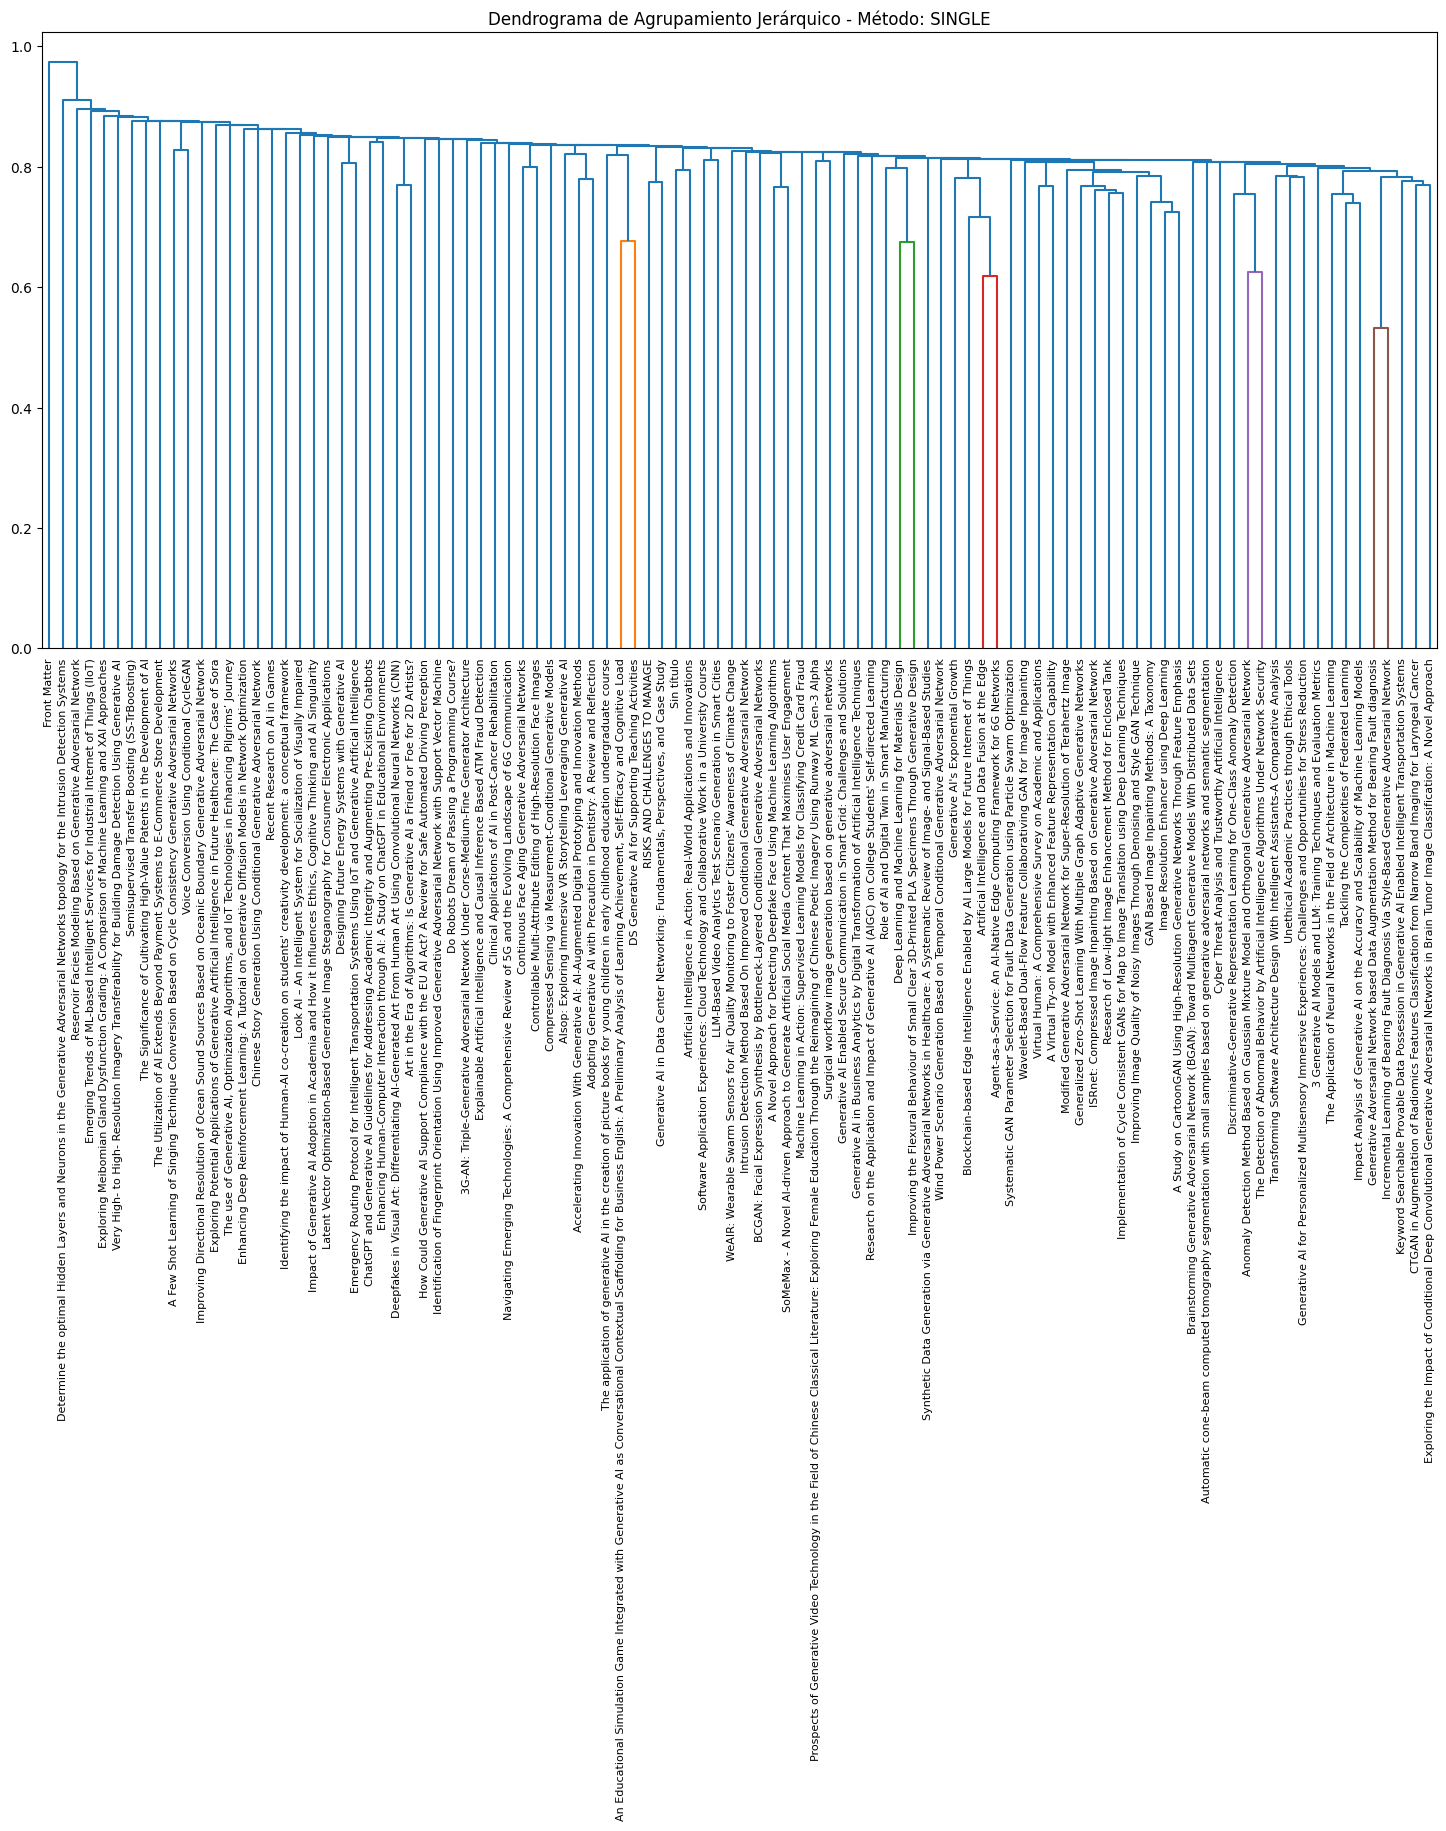


Generando dendrograma con método: COMPLETE...


/tmp/ipykernel_91635/108001267.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


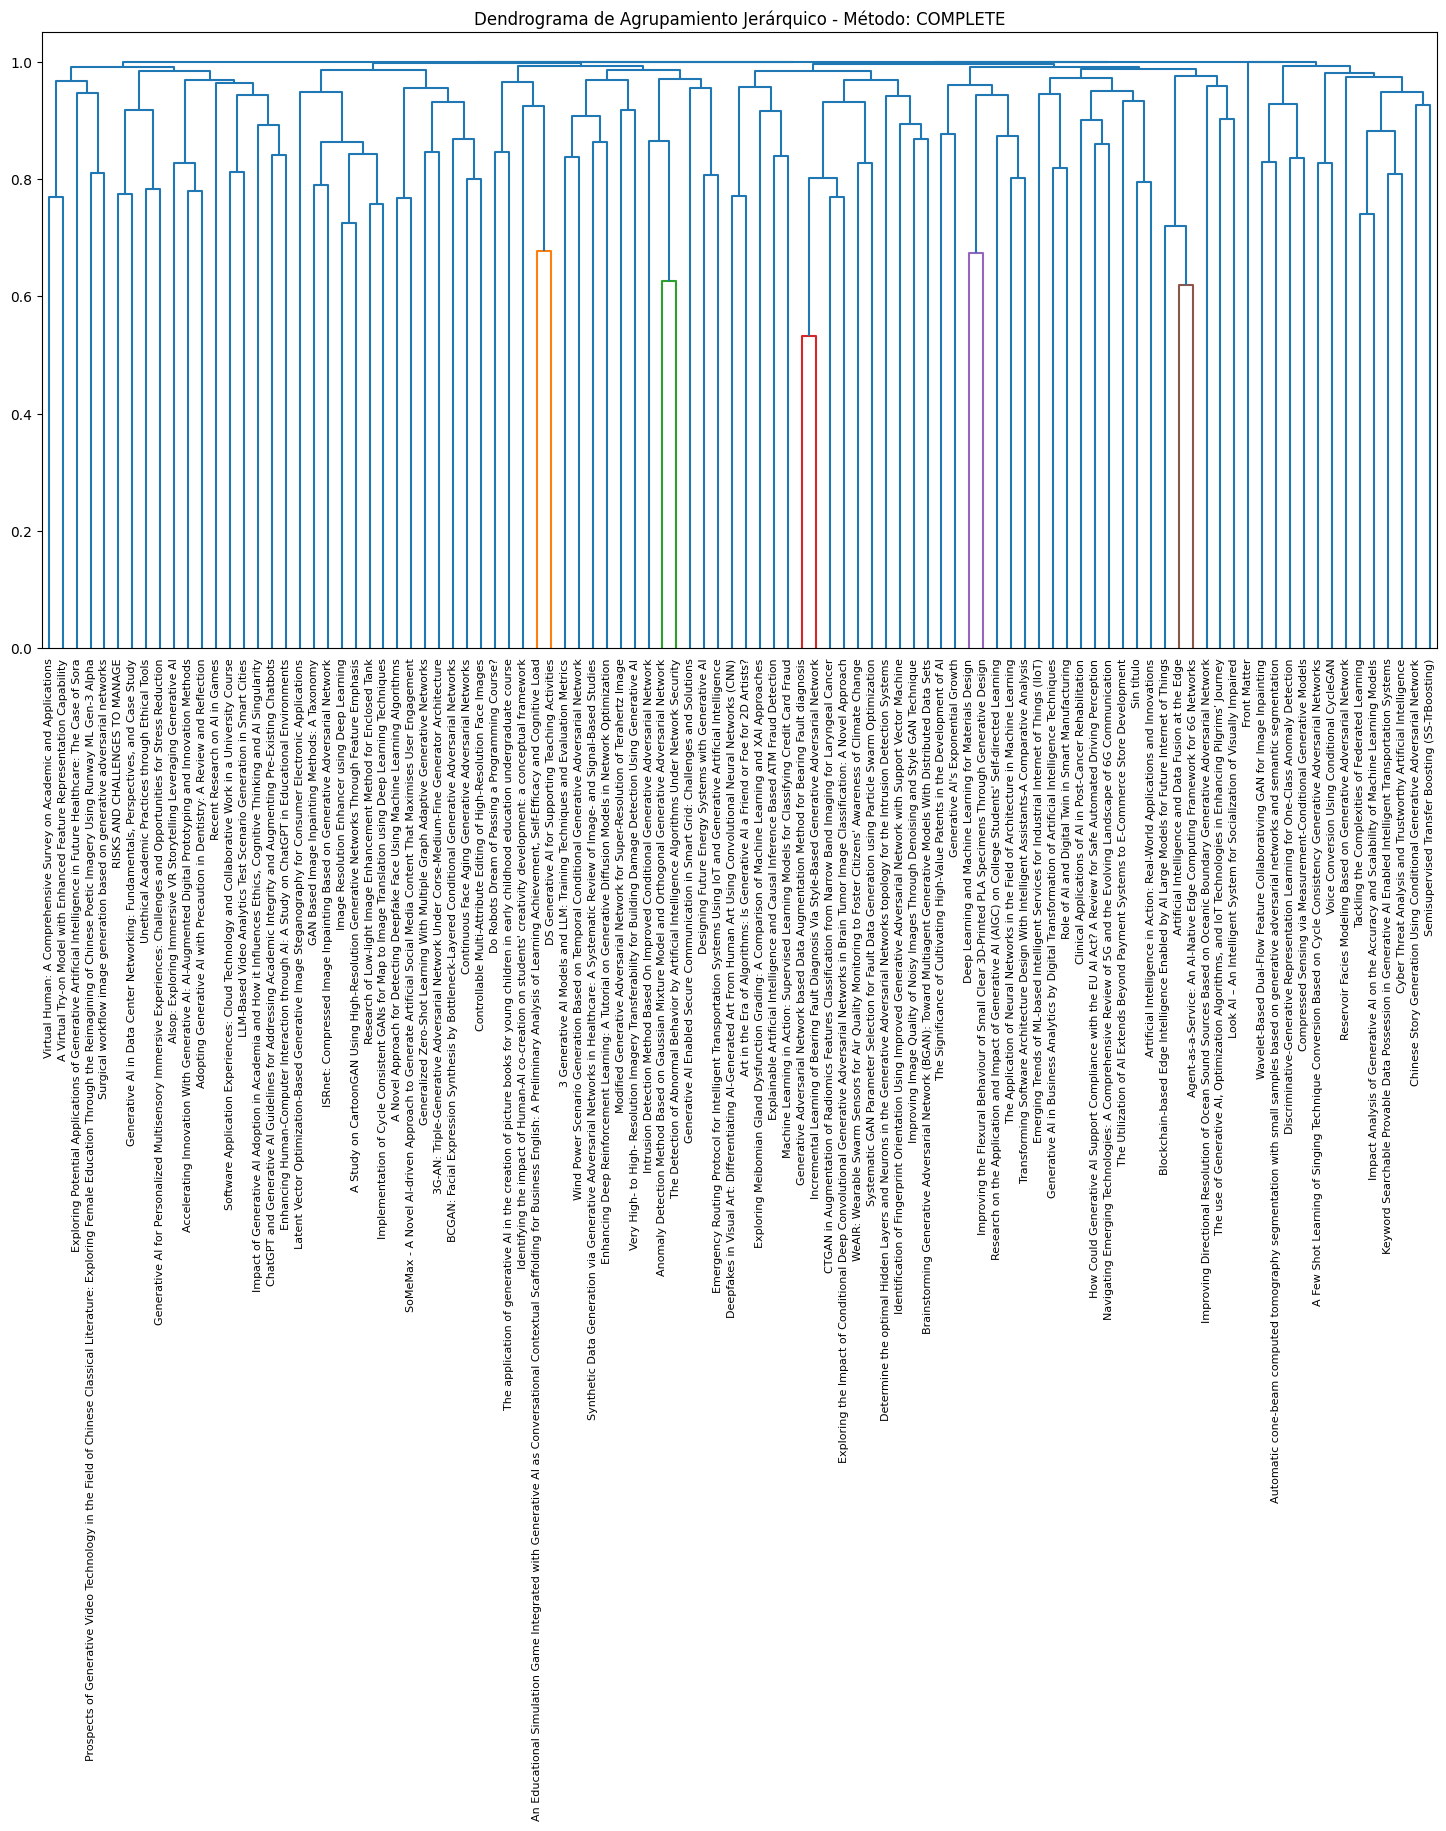


Generando dendrograma con método: AVERAGE...


/tmp/ipykernel_91635/108001267.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


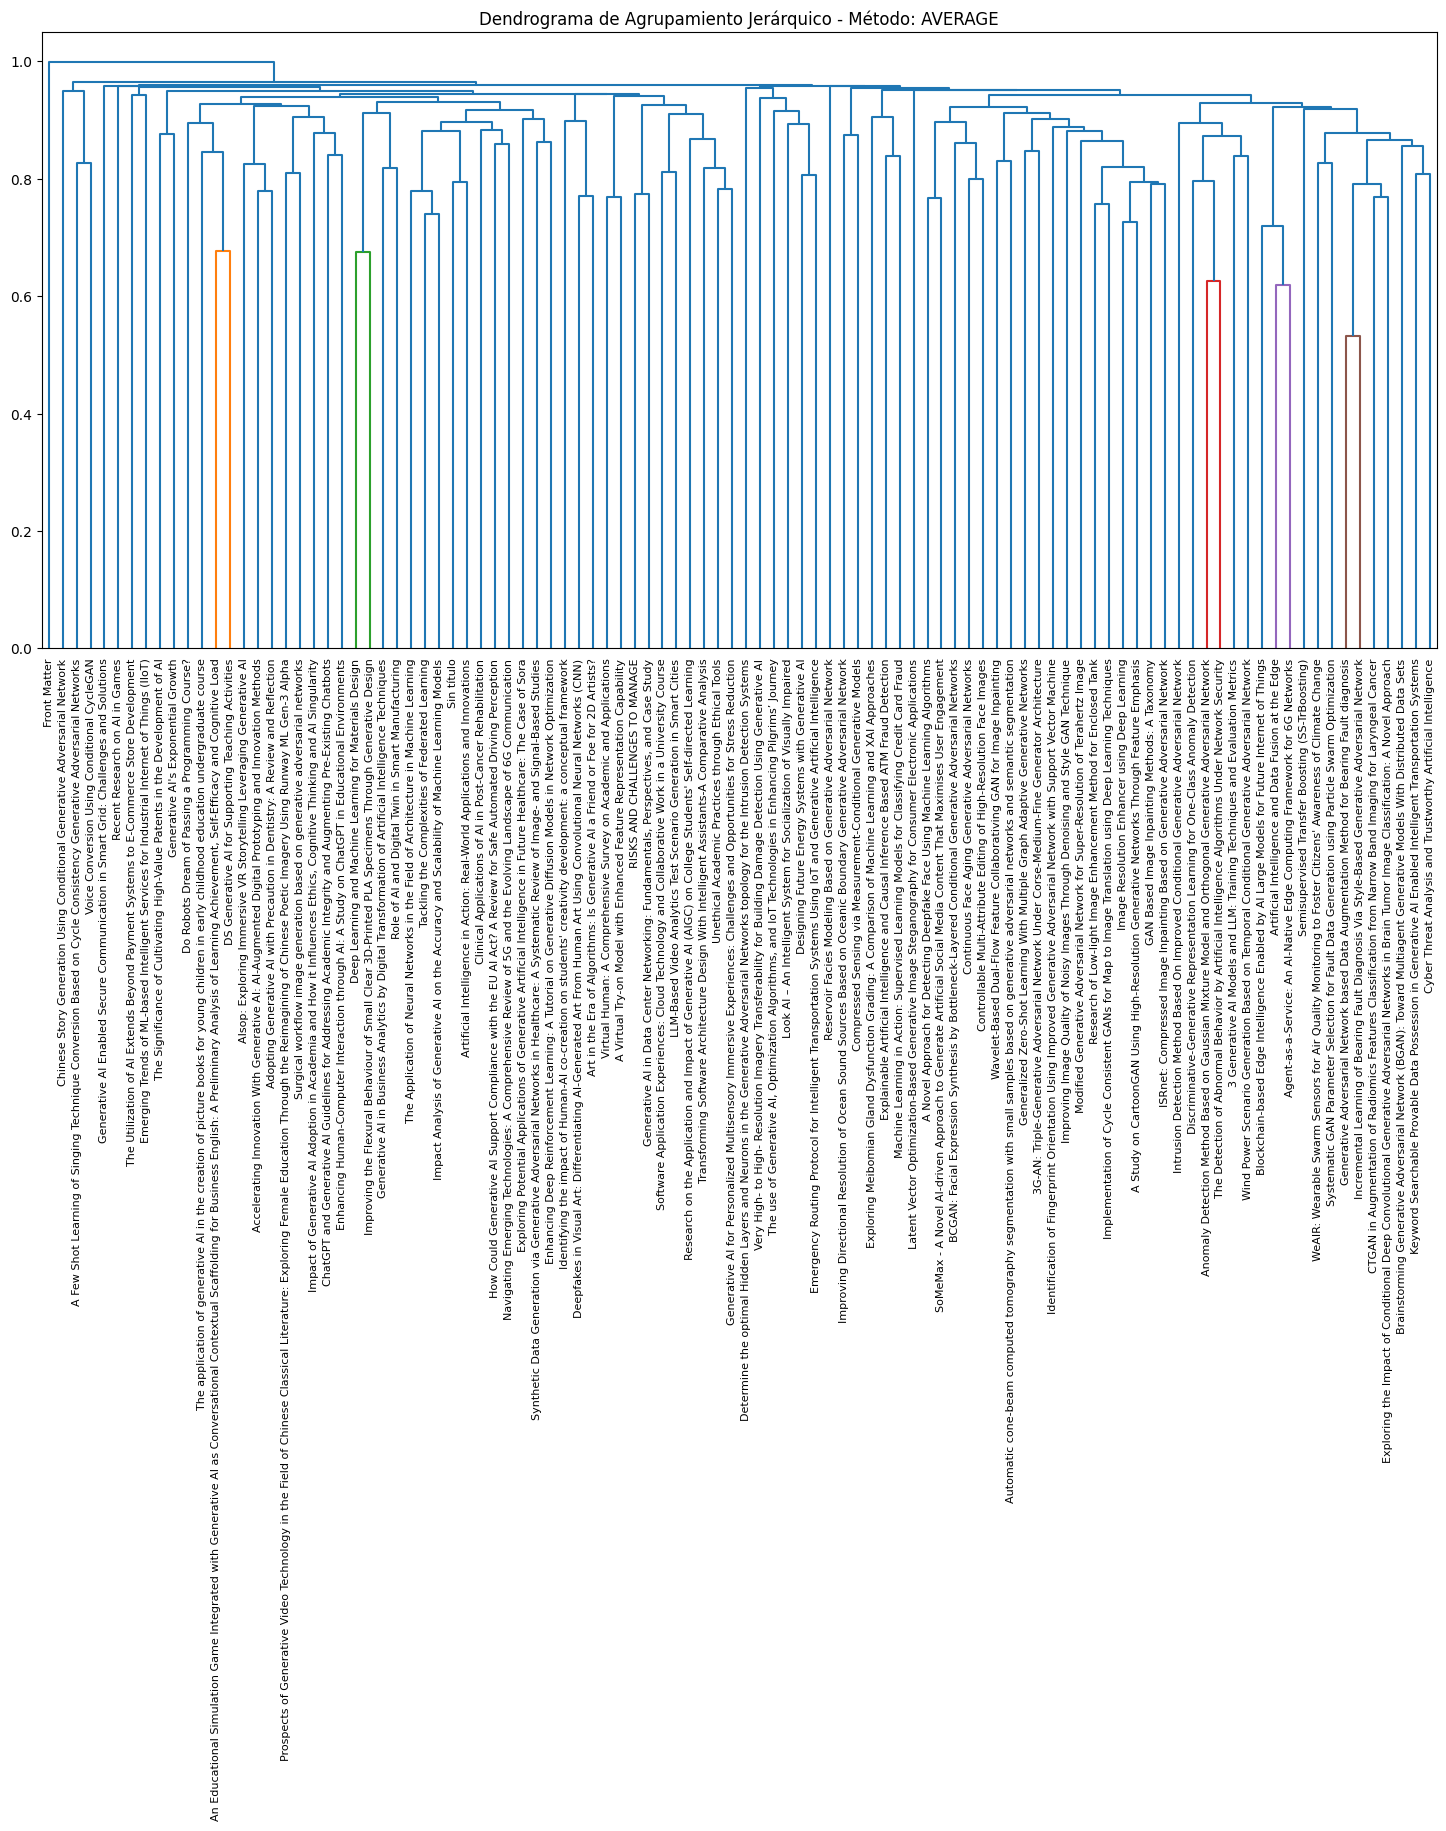

In [5]:
# Estos métodos determinan cómo se calcula la distancia entre grupos de documentos:
# - "single": usa la menor distancia entre dos puntos de diferentes clusters.
# - "complete": usa la mayor distancia entre dos puntos de diferentes clusters.
# - "average": usa el promedio de todas las distancias entre los puntos de los clusters.
metodos = ["single", "complete", "average"]


# Bucle principal para generar un dendrograma por cada método
for metodo in metodos:
    print(f"\nGenerando dendrograma con método: {metodo.upper()}...")

    # Se calcula la distancia entre cada par de abstracts usando la métrica del coseno.
    # La distancia coseno mide cuán similares son dos vectores TF-IDF:
    # - 0 → textos idénticos
    # - 1 → textos completamente diferentes
    dist_matrix = pdist(matriz_tfidf.toarray(), metric="cosine")

    # En algunos casos, la distancia coseno puede devolver valores NaN o infinitos
    # si hay vectores vacíos. np.nan_to_num() reemplaza esos valores por 0.
    dist_matrix = np.nan_to_num(dist_matrix, nan=0.0, posinf=0.0, neginf=0.0)

    # linkage() usa la matriz de distancias para construir la jerarquía de agrupamiento.
    # - 'method' define cómo se unen los clusters (según el método actual del bucle).
    # - El resultado 'Z' es una matriz que describe las fusiones de clusters paso a paso.
    Z = linkage(dist_matrix, method=metodo)

    # Se genera un gráfico jerárquico que muestra la similitud entre los abstracts.
    # Cada "rama" representa un grupo de textos que comparten palabras y contexto similar.
    plt.figure(figsize=(18, 8))
    plt.title(f"Dendrograma de Agrupamiento Jerárquico - Método: {metodo.upper()}")
    dendrogram(Z, labels=titulos_muestra, leaf_rotation=90, leaf_font_size=8)
    plt.tight_layout()
    plt.show()


### 📊 Análisis Comparativo de Métodos

A continuación se presenta un análisis detallado de los tres dendrogramas generados:

---

# Método SINGLE

El dendrograma del método single linkage muestra una estructura muy lineal, con casi todas las ramas conectadas a una altura cercana a 1.0.

Esto indica que los textos se van uniendo uno a uno por similitudes mínimas, generando un efecto conocido como “chaining” (encadenamiento).

En la práctica, este método no forma grupos definidos, sino que crea una cadena larga de uniones débiles.

Conclusión: Single linkage no es adecuado para este conjunto de abstracts, ya que no separa claramente los temas ni evidencia agrupamientos significativos.

#### 🔗 Single Linkage - Características Observadas:

**Ventajas**:
- ✅ Detecta relaciones débiles entre artículos
- ✅ Útil para identificar transiciones temáticas
- ✅ Muestra la "cadena" de similitud entre documentos

**Desventajas**:
- ❌ **Efecto chaining**: Clusters se alargan excesivamente
- ❌ Difícil identificar grupos compactos
- ❌ Sensible a artículos "puente" que conectan temas diferentes

**Interpretación**:
- Las fusiones ocurren a alturas muy bajas
- Muchos artículos se unen gradualmente
- Estructura menos clara de grupos temáticos

**Recomendación**: Usar solo para análisis exploratorio inicial

---

# Método COMPLETE

El método complete linkage muestra una estructura más balanceada, con una mayor cantidad de divisiones visibles y niveles de unión diferenciados.

La distancia entre los nodos superiores e inferiores indica que algunos grupos de abstracts comparten palabras o temas comunes, mientras otros se mantienen claramente separados.

Tiende a formar clusters más compactos y homogéneos, aunque algunos grupos pequeños se fusionan a distancias altas, lo que sugiere que todavía existen diferencias notables entre ellos.

Conclusión: Complete linkage mejora la coherencia visual y temática, permitiendo distinguir subconjuntos más consistentes, aunque aún conserva cierta dispersión entre ramas.

#### 🎯 Complete Linkage - Características Observadas:

**Ventajas**:
- ✅ Clusters muy compactos y bien definidos
- ✅ Separación clara entre grupos
- ✅ Menos sensible a outliers

**Desventajas**:
- ❌ Puede fragmentar clusters naturales grandes
- ❌ Tiende a crear grupos de tamaño similar
- ❌ Fusiones ocurren a alturas más altas

**Interpretación**:
- Grupos temáticos claramente diferenciados
- Artículos dentro de cada cluster son muy similares
- Útil para identificar subtemas específicos

**Recomendación**: Ideal para clasificación temática estricta

---

# Método AVERAGE

El dendrograma del método average linkage presenta una estructura jerárquica más equilibrada, con agrupamientos definidos y alturas intermedias de unión.

Las ramas están más uniformemente distribuidas, lo que indica una mayor estabilidad en las similitudes entre los abstracts.

Se observa una mejor separación entre grupos grandes, evitando el encadenamiento del método single y el sobreajuste del complete.

Conclusión: Average linkage logra una agrupación más coherente y representativa, reflejando relaciones temáticas más naturales entre los textos.

#### ⚖️ Average Linkage - Características Observadas:

**Ventajas**:
- ✅ **Balance óptimo** entre single y complete
- ✅ Clusters naturales y coherentes
- ✅ Menos sensible a outliers que single
- ✅ Más flexible que complete

**Desventajas**:
- ❌ Puede ser computacionalmente más costoso
- ❌ Requiere más memoria para datasets grandes

**Interpretación**:
- Estructura jerárquica más natural
- Buenos grupos temáticos sin fragmentación excesiva
- Altura de fusión refleja similitud promedio real

**Recomendación**: ⭐ **Método recomendado para análisis bibliométrico**

---

### 🎓 Conclusiones del Análisis:

| Criterio | Single | Complete | Average |
|----------|--------|----------|---------|
| **Compacidad** | Baja | Alta | Media |
| **Sensibilidad a outliers** | Alta | Media | Baja |
| **Interpretabilidad** | Baja | Alta | Alta |
| **Uso recomendado** | Exploración | Clasificación | General |

### 💡 Recomendaciones de Uso:

1. **Para este proyecto**: Usar **Average Linkage**
   - Balance entre precisión y flexibilidad
   - Clusters más naturales para artículos académicos

2. **Número óptimo de clusters**: 
   - Observar el dendrograma
   - Buscar "saltos" grandes en altura
   - Típicamente: 3-7 clusters para 100 artículos

3. **Validación**:
   - Revisar manualmente algunos artículos de cada cluster
   - Verificar coherencia temática
   - Ajustar si es necesario

---

## Método del Codo (Elbow Method)

Esta sección implementa el análisis del **Método del Codo** para determinar el número óptimo de clusters usando **K-Means**.

---